# Kaggle: Store Item Demand Forecasting Challenge

Kaggle [Store Item Demand Forecasting Challenge][kaggle] のデータセットでOptuna と LightGBM を利用した最適化のテストです。
特徴量は、 Kaggle Notebooks [My First Time Series Comp (Added Prophet)][adityaecdrid] 
をベースとしています。

[kaggle]: https://www.kaggle.com/c/demand-forecasting-kernels-only/overview
[adityaecdrid]: https://www.kaggle.com/adityaecdrid/my-first-time-series-comp-added-prophet


## パッケージの追加

In [1]:
!pip install kaggle
!pip install optuna

     |████████████████████████████████| 163kB 4.7MB/s 
     |████████████████████████████████| 1.1MB 9.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
     |████████████████████████████████| 51kB 9.6MB/s 
     |████████████████████████████████| 112kB 25.6MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=90e33e9d6e9f7f02f0b4127636fd02cad9c03ba142bbc7370f8a1b926da4e8a4
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.3.0-cp36-none-any.whl size=221121 sha256=117e9e566e5984ac08f643e4692165515e9477ed76e02949426a575f415a5709
  Stored in directory: /root/.cache/pip/wheels/62/

## Import

In [0]:
# default packages
import datetime
import logging
import pathlib
import pprint

In [3]:
# third party packages
import google.colab.drive as drive
import IPython.display as display
import optuna.integration.lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import tqdm.notebook as tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [0]:
# auto reload
%load_ext autoreload
%autoreload 2

In [0]:
# graph settigns
sns.set()

In [0]:
# logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

## フォルダ構成の生成

In [0]:
data_dir = pathlib.Path("data")
raw_dir = data_dir.joinpath("raw")

data_dir.mkdir(exist_ok=True)
raw_dir.mkdir(exist_ok=True)

## Google Drive のマウント


In [8]:
def mount_gdrive() -> pathlib.Path:
    """Google Drive をマウントし、必要なディレクトリへのシンボリックリンクを設定する."""
    gdrive_base = pathlib.Path("/content/drive")
    gdrive_cache = gdrive_base.joinpath("My Drive/storeItemDemandForecastingChallenge")
    gdrive_kaggle = gdrive_base.joinpath("My Drive/kaggle")

    kaggle_dir = pathlib.Path("./kaggle")
    cache_dir = pathlib.Path("./cache")

    if gdrive_base.exists() is False:
        drive.mount(str(gdrive_base))
    if cache_dir.exists() is False:
        !ln -s "$gdrive_cache" "$cache_dir"
    if kaggle_dir.exists() is False:
        !ln -s "$gdrive_kaggle" "$kaggle_dir"

    return cache_dir, kaggle_dir


cache_dir, kaggle_dir = mount_gdrive()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Kaggle API の有効化

In [0]:
def activate_kaggle_api(gdrive_kaggle: pathlib.Path) -> None:
    """Kaggle API を有効化するための token を Google Drive からコピーする."""
    kaggle_file = "kaggle.json"
    gdrive_kaggle_json = gdrive_kaggle.joinpath(kaggle_file)
    local_kaggle_dir = pathlib.Path("/root/.kaggle")
    local_kaggle_json = local_kaggle_dir.joinpath(kaggle_file)

    local_kaggle_dir.mkdir(exist_ok=True)
    !cp "$gdrive_kaggle_json" "$local_kaggle_json"
    !chmod 600 "$local_kaggle_json"


activate_kaggle_api(kaggle_dir)

## データセットの読み込み

In [10]:
!kaggle competitions download -c demand-forecasting-kernels-only -p "$raw_dir"

  0% 0.00/3.06M [00:00<?, ?B/s]
100% 3.06M/3.06M [00:00<00:00, 103MB/s]
  0% 0.00/952k [00:00<?, ?B/s]
100% 952k/952k [00:00<00:00, 134MB/s]
  0% 0.00/385k [00:00<?, ?B/s]
100% 385k/385k [00:00<00:00, 103MB/s]


In [0]:
df_raw = pd.read_csv(raw_dir.joinpath("train.csv.zip"), low_memory=False, parse_dates=["date"], index_col=["date"]).sort_index()
df_test = pd.read_csv(raw_dir.joinpath("test.csv"), low_memory=False, parse_dates=["date"], index_col=["date"]).sort_index()
df_subs = pd.read_csv(raw_dir.joinpath("sample_submission.csv")).sort_index()

In [12]:
display.display(df_raw.info())
display.display(df_raw.head())
display.display(df_raw.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


None

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-01,7,12,26
2013-01-01,7,46,27
2013-01-01,8,12,54
2013-01-01,9,12,35


,store,item,sales
date,,,
2017-12-31,9,34,21
2017-12-31,10,34,32
2017-12-31,1,35,55
2017-12-31,8,33,100
2017-12-31,10,50,82


In [13]:
display.display(df_test.info())
display.display(df_test.head())
display.display(df_test.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45000 entries, 2018-01-01 to 2018-03-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      45000 non-null  int64
 1   store   45000 non-null  int64
 2   item    45000 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


None

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-01,32940,7,37
2018-01-01,3960,5,5
2018-01-01,32850,6,37
2018-01-01,32760,5,37


,id,store,item
date,,,
2018-03-31,30149,5,34
2018-03-31,30239,6,34
2018-03-31,30329,7,34
2018-03-31,30509,9,34
2018-03-31,44999,10,50


In [14]:
display.display(df_subs.info())
display.display(df_subs.head())
display.display(df_subs.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      45000 non-null  int64
 1   sales   45000 non-null  int64
dtypes: int64(2)
memory usage: 703.2 KB


None

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


,id,sales
44995,44995,52
44996,44996,52
44997,44997,52
44998,44998,52
44999,44999,52


## 特徴量を追加

In [15]:
def add_datepart(df_target: pd.DataFrame) -> pd.DataFrame:
    """日付に関する情報を付与した列を追加する."""
    date_series = df_target.index.to_series()
    attr = [
        "Year",
        "Month",
        "Week",
        "Day",
        "Dayofweek",
        "Dayofyear",
        "weekofyear",
        "Is_month_end",
        "Is_month_start",
        "Is_quarter_end",
        "Is_quarter_start",
        "Is_year_end",
        "Is_year_start"
    ]
    
    df = df_target.copy()
    for name in attr: 
        df[name] = getattr(date_series.dt, name.lower())

    return df


df_datepart = add_datepart(df_raw)
display.display(df_datepart.head())

,store,item,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,weekofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
date,,,,,,,,,,,,,,,,
2013-01-01,1,1,13,2013,1,1,1,1,1,1,False,True,False,True,False,True
2013-01-01,7,12,26,2013,1,1,1,1,1,1,False,True,False,True,False,True
2013-01-01,7,46,27,2013,1,1,1,1,1,1,False,True,False,True,False,True
2013-01-01,8,12,54,2013,1,1,1,1,1,1,False,True,False,True,False,True
2013-01-01,9,12,35,2013,1,1,1,1,1,1,False,True,False,True,False,True


In [16]:
def extract_feature(df_target: pd.DataFrame) -> pd.DataFrame:
    """集計した特徴量とラグ特徴量を追加する.
    """
    df = df_target.copy()
    df["sales"], _ = stats.boxcox(df_target["sales"] + 1)

    df["median-store_item"] = df.groupby(["item", "store"])["sales"].transform("median")
    df["mean-store_item"] = df.groupby(["item", "store"])["sales"].transform("mean")
    df["median-month_item"] = df.groupby(["Month", "item"])["sales"].transform("median")
    df["mean-month_item"] = df.groupby(["Month", "item"])["sales"].transform("mean")
    df["median-month_store"] = df.groupby(["Month", "store"])["sales"].transform("median")

    df["median-item"] = df.groupby(["item"])["sales"].transform("median")
    df["mean-item"] = df.groupby(["item"])["sales"].transform("mean")
    df["median-store"] = df.groupby(["store"])["sales"].transform("median")
    df["mean-store"] = df.groupby(["store"])["sales"].transform("mean")

    df["median-store_item-month"] = df.groupby(["Month", "item", "store"])["sales"].transform("median")
    df["mean-store_item-week"] = df.groupby(["item", "store", "weekofyear"])["sales"].transform("mean")

    df["item-month-mean"] = df.groupby(["Month", "item"])["sales"].transform("mean")
    df["store-month-mean"] = df.groupby(["Month", "store"])["sales"].transform("mean")
    
    lags = [91, 182, 365]
    for lag in lags:
        groups = df.groupby(["item", "store"])["sales"]
        shift_sales = groups.transform(lambda x: x.shift(lag)).to_frame()
        shift_sales.columns = ["sales_shift"]
        shift_sales["item"] = df["item"]
        shift_sales["store"] = df["store"]
        shift_sales["weekofyear"] = df["weekofyear"]

        groups = shift_sales.groupby(["item", "weekofyear"])["sales_shift"]
        df[f"item-week_shifted-{lag}_sum"] = groups.transform("sum")
        df[f"item-week_shifted-{lag}_mean"] = groups.transform("mean")

        groups = shift_sales.groupby(["store", "weekofyear"])["sales_shift"]
        df[f"store-week_shifted-{lag}_sum"] = groups.transform("sum")
        df[f"store-week_shifted-{lag}_mean"] = groups.transform("mean")

    return df


train_flag = (df_raw.index < datetime.datetime(2017, 1, 1))
df_train = df_datepart.loc[train_flag]
df_valid = df_datepart.loc[train_flag == False]
%time df_train_feature = extract_feature(df_train)
display.display(df_train_feature.info())
display.display(df_train_feature.head())
display.display(df_train_feature.tail())

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


CPU times: user 3.58 s, sys: 139 ms, total: 3.72 s
Wall time: 3.74 s
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730500 entries, 2013-01-01 to 2016-12-31
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   store                        730500 non-null  int64  
 1   item                         730500 non-null  int64  
 2   sales                        730500 non-null  float64
 3   Year                         730500 non-null  int64  
 4   Month                        730500 non-null  int64  
 5   Week                         730500 non-null  int64  
 6   Day                          730500 non-null  int64  
 7   Dayofweek                    730500 non-null  int64  
 8   Dayofyear                    730500 non-null  int64  
 9   weekofyear                   730500 non-null  int64  
 10  Is_month_end                 730500 non-null  bool   
 11  Is_month_start               730

None

,store,item,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,weekofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,median-store_item,mean-store_item,median-month_item,mean-month_item,median-month_store,median-item,mean-item,median-store,mean-store,median-store_item-month,mean-store_item-week,item-month-mean,store-month-mean,item-week_shifted-91_sum,item-week_shifted-91_mean,store-week_shifted-91_sum,store-week_shifted-91_mean,item-week_shifted-182_sum,item-week_shifted-182_mean,store-week_shifted-182_sum,store-week_shifted-182_mean,item-week_shifted-365_sum,item-week_shifted-365_mean,store-week_shifted-365_sum,store-week_shifted-365_mean
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,3.818101,2013,1,1,1,1,1,1,False,True,False,True,False,True,4.569984,4.527395,3.958059,3.904389,5.596474,4.678463,4.697014,6.506714,6.411065,3.818101,3.821127,3.904389,5.472455,963.756472,4.589317,6624.166161,6.308730,1084.552153,5.164534,7345.195287,6.995424,731.908797,3.852152,5125.572205,5.395339
2013-01-01,7,12,5.259961,2013,1,1,1,1,1,1,False,True,False,True,False,True,6.687790,6.663152,6.628401,6.586085,4.982614,7.671526,7.655170,5.828441,5.740995,5.752854,5.795187,6.586085,4.873571,1590.624040,7.574400,5938.527052,5.655740,1757.588498,8.369469,6613.029960,6.298124,1232.660227,6.487685,4550.466451,4.789965
2013-01-01,7,46,5.347358,2013,1,1,1,1,1,1,False,True,False,True,False,True,6.250575,6.197591,6.183614,6.152525,4.982614,7.184414,7.152859,5.828441,5.740995,5.259961,5.380408,6.152525,4.873571,1469.902759,6.999537,5938.527052,5.655740,1643.104769,7.824308,6613.029960,6.298124,1155.420020,6.081158,4550.466451,4.789965
2013-01-01,8,12,7.132271,2013,1,1,1,1,1,1,False,True,False,True,False,True,8.425967,8.346525,6.628401,6.586085,6.380888,7.671526,7.655170,7.336841,7.256256,7.158343,7.300378,6.586085,6.243566,1590.624040,7.574400,7508.759995,7.151200,1757.588498,8.369469,8298.976609,7.903787,1232.660227,6.487685,5822.322075,6.128760
2013-01-01,9,12,5.974842,2013,1,1,1,1,1,1,False,True,False,True,False,True,7.894915,7.857984,6.628401,6.586085,5.974842,7.671526,7.655170,6.916448,6.823100,6.803835,6.807733,6.586085,5.838914,1590.624040,7.574400,7054.560930,6.718629,1757.588498,8.369469,7818.530826,7.446220,1232.660227,6.487685,5472.253941,5.760267


,store,item,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,weekofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,median-store_item,mean-store_item,median-month_item,mean-month_item,median-month_store,median-item,mean-item,median-store,mean-store,median-store_item-month,mean-store_item-week,item-month-mean,store-month-mean,item-week_shifted-91_sum,item-week_shifted-91_mean,store-week_shifted-91_sum,store-week_shifted-91_mean,item-week_shifted-182_sum,item-week_shifted-182_mean,store-week_shifted-182_sum,store-week_shifted-182_mean,item-week_shifted-365_sum,item-week_shifted-365_mean,store-week_shifted-365_sum,store-week_shifted-365_mean
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-12-31,6,18,7.435320,2016,12,52,31,5,366,52,True,False,True,False,True,False,7.483671,7.431869,7.435320,7.404443,5.432488,8.269425,8.240876,6.045808,5.963236,6.746257,6.715737,7.404443,5.299893,2268.328656,8.401217,8226.254044,6.093522,2398.228910,8.882329,8727.592490,6.464883,1452.024881,7.260124,5188.108846,5.188109
2016-12-31,1,42,5.675562,2016,12,52,31,5,366,52,True,False,True,False,True,False,5.675562,5.685750,5.259961,5.236845,5.828441,5.902411,5.897281,6.506714,6.411065,5.170150,4.938028,5.236845,5.716837,1628.825925,6.032689,8859.917310,6.562902,1727.960921,6.399855,9361.032087,6.934098,1025.364601,5.126823,5598.946972,5.598947
2016-12-31,4,6,6.380888,2016,12,52,31,5,366,52,True,False,True,False,True,False,7.386382,7.327198,6.444339,6.380553,6.183614,7.132271,7.145702,6.860556,6.817291,6.506714,6.504196,6.380553,6.088225,1957.401493,7.249635,9377.157795,6.946043,2090.665214,7.743204,9965.219247,7.381644,1252.763950,6.263820,5975.750192,5.975750
2016-12-31,9,4,4.340450,2016,12,52,31,5,366,52,True,False,True,False,True,False,4.884505,4.842769,4.218579,4.131074,6.183614,4.678463,4.706085,6.916448,6.823100,4.340450,4.297271,4.131074,6.087868,1292.656353,4.787616,9413.245655,6.972775,1387.897042,5.140359,9966.933974,7.382914,795.216262,3.976081,5962.370140,5.962370
2016-12-31,3,33,8.065436,2016,12,52,31,5,366,52,True,False,True,False,True,False,8.148197,8.090959,6.916448,6.875107,6.444339,7.671526,7.651051,7.132271,7.041855,7.286679,7.369958,6.875107,6.299059,2109.509410,7.812998,9705.850091,7.189519,2223.289745,8.234406,10260.244896,7.600181,1351.527638,6.757638,6162.400638,6.162401


In [41]:
def set_test_feature(source: pd.DataFrame, df_target: pd.DataFrame) -> pd.DataFrame:
    """ テストデータに対して近傍のデータから値を設定する.

    Notes:
        - fillna などを行うよりも transform してしまったほうが、計算速度がかなり速いため、
            最頻値(Noneを除く)で埋めるように設定。
    """
    target = df_target.copy()
    columns = set(source.columns) - set(df_target.columns)
    for column in columns:
        target[column] = None

    source_group = source.groupby(["store", "item", "weekofyear"]).agg("median")
    df_source = source_group.reset_index()
    df_merge = pd.concat([df_source, target], axis=0)
    for column in tqdm.tqdm(columns):
        df_merge[column] = df_merge.groupby(["store", "item", "weekofyear"])[column].transform(lambda x: x.mode()[0])

    df_merge = df_merge.iloc[df_source.shape[0]:].reset_index()
    df_merge = df_merge.rename(columns={"index": "date"})
    df_merge["date"] = pd.to_datetime(df_merge["date"])
    df_merge = df_merge.set_index(["date"])
    return df_merge

%time df_test_feature = set_test_feature(df_train_feature, df_valid)
logger.info(df_test_feature.info())
display.display(df_test_feature.head())
display.display(df_test_feature.tail())

INFO:__main__:None



CPU times: user 4min 51s, sys: 1.15 s, total: 4min 52s
Wall time: 4min 53s
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 182500 entries, 2017-01-01 to 2017-12-31
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   store                        182500 non-null  int64  
 1   item                         182500 non-null  int64  
 2   weekofyear                   182500 non-null  int64  
 3   sales                        182500 non-null  float64
 4   Year                         182500 non-null  float64
 5   Month                        182500 non-null  float64
 6   Week                         182500 non-null  float64
 7   Day                          182500 non-null  float64
 8   Dayofweek                    182500 non-null  float64
 9   Dayofyear                    182500 non-null  float64
 10  Is_month_end                 182500 non-null  bool   
 11  Is_month_start           

,store,item,weekofyear,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,median-store_item,mean-store_item,median-month_item,mean-month_item,median-month_store,median-item,mean-item,median-store,mean-store,median-store_item-month,mean-store_item-week,item-month-mean,store-month-mean,item-week_shifted-91_sum,item-week_shifted-91_mean,store-week_shifted-91_sum,store-week_shifted-91_mean,item-week_shifted-182_sum,item-week_shifted-182_mean,store-week_shifted-182_sum,store-week_shifted-182_mean,item-week_shifted-365_sum,item-week_shifted-365_mean,store-week_shifted-365_sum,store-week_shifted-365_mean
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,4,27,52,18.0,2017.0,1.0,52.0,1.0,6.0,1.0,False,True,False,True,False,True,4.884505,4.843058,4.218579,4.131065,6.183614,4.783206,4.705122,6.860556,6.817291,4.218579,4.203570,4.131065,6.088225,1288.708216,4.772993,9377.157795,6.946043,1392.193496,5.156272,9965.219247,7.381644,812.844848,4.064224,5975.750192,5.975750
2017-01-01,1,39,52,36.0,2017.0,1.0,52.0,1.0,6.0,1.0,False,True,False,True,False,True,6.183614,6.130313,5.675562,5.644907,5.828441,6.380888,6.354694,6.506714,6.411065,5.515486,5.482372,5.644907,5.716837,1752.567980,6.490993,8859.917310,6.562902,1854.218436,6.867476,9361.032087,6.934098,1105.277448,5.526387,5598.946972,5.598947
2017-01-01,1,46,52,38.0,2017.0,1.0,52.0,1.0,6.0,1.0,False,True,False,True,False,True,6.916448,6.896732,6.380888,6.390554,5.828441,7.184414,7.152859,6.506714,6.411065,6.183614,6.110280,6.390554,5.716837,1968.337516,7.290139,8859.917310,6.562902,2089.097345,7.737398,9361.032087,6.934098,1252.954416,6.264772,5598.946972,5.598947
2017-01-01,7,29,52,43.0,2017.0,1.0,52.0,1.0,6.0,1.0,False,True,False,True,False,True,6.687790,6.666370,6.860556,6.847176,5.170150,7.671526,7.653941,5.828441,5.740995,5.974842,5.864579,6.847176,5.084258,2118.524733,7.846388,7913.085842,5.861545,2216.955772,8.210947,8439.921166,6.251793,1342.669579,6.713348,4964.100166,4.964100
2017-01-01,9,35,52,66.0,2017.0,1.0,52.0,1.0,6.0,1.0,False,True,False,True,False,True,7.762327,7.698499,6.746257,6.699870,6.183614,7.483671,7.485798,6.916448,6.823100,6.971539,6.769206,6.699870,6.087868,2055.398482,7.612587,9413.245655,6.972775,2180.170888,8.074707,9966.933974,7.382914,1321.989665,6.609948,5962.370140,5.962370


,store,item,weekofyear,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,median-store_item,mean-store_item,median-month_item,mean-month_item,median-month_store,median-item,mean-item,median-store,mean-store,median-store_item-month,mean-store_item-week,item-month-mean,store-month-mean,item-week_shifted-91_sum,item-week_shifted-91_mean,store-week_shifted-91_sum,store-week_shifted-91_mean,item-week_shifted-182_sum,item-week_shifted-182_mean,store-week_shifted-182_sum,store-week_shifted-182_mean,item-week_shifted-365_sum,item-week_shifted-365_mean,store-week_shifted-365_sum,store-week_shifted-365_mean
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-31,9,34,52,21.0,2017.0,12.0,52.0,31.0,6.0,365.0,True,False,True,False,True,False,5.259961,5.194369,4.457439,4.425416,6.183614,5.077762,5.047284,6.916448,6.823100,4.569984,4.431315,4.425416,6.087868,1399.561865,5.183562,9413.245655,6.972775,1465.613591,5.428198,9966.933974,7.382914,860.842323,4.304212,5962.370140,5.962370
2017-12-31,10,34,52,32.0,2017.0,12.0,52.0,31.0,6.0,365.0,True,False,True,False,True,False,5.432488,5.346731,4.457439,4.425416,6.380888,5.077762,5.047284,7.079427,7.004692,4.678463,4.716520,4.425416,6.262600,1399.561865,5.183562,9663.318867,7.158014,1465.613591,5.428198,10194.644039,7.551588,860.842323,4.304212,6169.654765,6.169655
2017-12-31,1,35,52,55.0,2017.0,12.0,52.0,31.0,6.0,365.0,True,False,True,False,True,False,7.286679,7.236364,6.746257,6.699870,5.828441,7.483671,7.485798,6.506714,6.411065,6.506714,6.566906,6.699870,5.716837,2055.398482,7.612587,8859.917310,6.562902,2180.170888,8.074707,9361.032087,6.934098,1321.989665,6.609948,5598.946972,5.598947
2017-12-31,8,33,52,100.0,2017.0,12.0,52.0,31.0,6.0,365.0,True,False,True,False,True,False,8.387354,8.323073,6.916448,6.875107,6.628401,7.671526,7.651051,7.336841,7.256256,7.531452,7.360680,6.875107,6.495521,2109.509410,7.812998,9975.714714,7.389418,2223.289745,8.234406,10587.953565,7.842929,1351.527638,6.757638,6377.367273,6.377367
2017-12-31,10,50,52,82.0,2017.0,12.0,52.0,31.0,6.0,365.0,True,False,True,False,True,False,7.938195,7.890958,6.746257,6.720741,6.380888,7.531452,7.493466,7.079427,7.004692,7.184414,7.087141,6.720741,6.262600,2071.396198,7.671838,9663.318867,7.158014,2181.879090,8.081034,10194.644039,7.551588,1319.101525,6.595508,6169.654765,6.169655


## LightGBM Optuna Tuner による最適化

In [70]:
def train_gbm(train_feature: pd.DataFrame):
    train_index = (train_feature.index < datetime.datetime(2016, 1, 1))
    valid_index = (train_index == False)

    train_y = train_feature.loc[train_index, "sales"]
    train_x = train_feature.loc[train_index].reset_index().drop(["date", "sales"], axis=1)
    valid_y = train_feature.loc[valid_index, "sales"]
    valid_x = train_feature.loc[valid_index].reset_index().drop(["date", "sales"], axis=1)

    logger.info(train_x.info())
    logger.info(valid_x.info())

    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_valid = lgb.Dataset(valid_x, valid_y)
    params = {
        "objective": "regression_l1",
        "metric": "mape",
        "boosting_type": "gbdt",
        "nthread": 4,
        "verbose": -1,
    }

    best_params, tuning_history = dict(), list()
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_valid],
        best_params=best_params,
        tuning_history=tuning_history,
        verbose_eval=100,
        early_stopping_rounds=100,
    )

    return model, best_params, tuning_history


%time lgb_model, lgb_best_params, lgb_tuning_history = train_gbm(df_train_feature)

INFO:__main__:None
INFO:__main__:None
/usr/local/lib/python3.6/dist-packages/optuna/_experimental.py:90: ExperimentalWarning:

train is experimental (supported from v0.18.0). The interface can change in the future.



  0%|          | 0/7 [00:00<?, ?it/s]

tune_feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547500 entries, 0 to 547499
Data columns (total 40 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   store                        547500 non-null  int64  
 1   item                         547500 non-null  int64  
 2   Year                         547500 non-null  int64  
 3   Month                        547500 non-null  int64  
 4   Week                         547500 non-null  int64  
 5   Day                          547500 non-null  int64  
 6   Dayofweek                    547500 non-null  int64  
 7   Dayofyear                    547500 non-null  int64  
 8   weekofyear                   547500 non-null  int64  
 9   Is_month_end                 547500 non-null  bool   
 10  Is_month_start               547500 non-null  bool   
 11  Is_quarter_end               547500 non-null  bool   
 12  Is_quarter_start             547500 non-null  bool   
 13 



tune_feature_fraction, val_score: 0.055861:   0%|          | 0/7 [00:20<?, ?it/s]

tune_feature_fraction, val_score: 0.055861:  14%|#4        | 1/7 [00:20<02:04, 20.74s/it][I 2020-04-05 13:50:11,628] Finished trial#0 with value: 0.055861040491323524 with parameters: {'feature_fraction': 0.4}. Best is trial#0 with value: 0.055861040491323524.


tune_feature_fraction, val_score: 0.055861:  14%|#4        | 1/7 [00:20<02:04, 20.74s/it]

Early stopping, best iteration is:
[244]	training's mape: 0.055308	valid_1's mape: 0.055861
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0556901	valid_1's mape: 0.0560939
[200]	training's mape: 0.0553579	valid_1's mape: 0.0559179
[300]	training's mape: 0.0551723	valid_1's mape: 0.0559297




tune_feature_fraction, val_score: 0.055911:  14%|#4        | 1/7 [00:39<02:04, 20.74s/it]

tune_feature_fraction, val_score: 0.055911:  29%|##8       | 2/7 [00:39<01:40, 20.04s/it][I 2020-04-05 13:50:30,029] Finished trial#1 with value: 0.05591094032883762 with parameters: {'feature_fraction': 0.5}. Best is trial#1 with value: 0.05591094032883762.


tune_feature_fraction, val_score: 0.055911:  29%|##8       | 2/7 [00:39<01:40, 20.04s/it]

Early stopping, best iteration is:
[218]	training's mape: 0.0553176	valid_1's mape: 0.0559109
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0556285	valid_1's mape: 0.0561811
[200]	training's mape: 0.0553305	valid_1's mape: 0.0560616
[300]	training's mape: 0.0551517	valid_1's mape: 0.0560329
[400]	training's mape: 0.0549989	valid_1's mape: 0.0560246




tune_feature_fraction, val_score: 0.056016:  29%|##8       | 2/7 [01:05<01:40, 20.04s/it]

tune_feature_fraction, val_score: 0.056016:  43%|####2     | 3/7 [01:05<01:27, 21.79s/it][I 2020-04-05 13:50:55,900] Finished trial#2 with value: 0.05601567589827215 with parameters: {'feature_fraction': 0.6}. Best is trial#2 with value: 0.05601567589827215.


tune_feature_fraction, val_score: 0.056016:  43%|####2     | 3/7 [01:05<01:27, 21.79s/it]

Early stopping, best iteration is:
[354]	training's mape: 0.0550641	valid_1's mape: 0.0560157
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0555597	valid_1's mape: 0.0562224
[200]	training's mape: 0.0552854	valid_1's mape: 0.0561132
[300]	training's mape: 0.0551209	valid_1's mape: 0.0560802
[400]	training's mape: 0.0549821	valid_1's mape: 0.056084




tune_feature_fraction, val_score: 0.056072:  43%|####2     | 3/7 [01:30<01:27, 21.79s/it]

tune_feature_fraction, val_score: 0.056072:  57%|#####7    | 4/7 [01:30<01:09, 23.03s/it][I 2020-04-05 13:51:21,826] Finished trial#3 with value: 0.05607184649305867 with parameters: {'feature_fraction': 0.7}. Best is trial#3 with value: 0.05607184649305867.


tune_feature_fraction, val_score: 0.056072:  57%|#####7    | 4/7 [01:31<01:09, 23.03s/it]

Early stopping, best iteration is:
[334]	training's mape: 0.0550726	valid_1's mape: 0.0560718
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.055544	valid_1's mape: 0.0562008
[200]	training's mape: 0.0552818	valid_1's mape: 0.056067
[300]	training's mape: 0.0551047	valid_1's mape: 0.0560581




tune_feature_fraction, val_score: 0.056072:  57%|#####7    | 4/7 [01:56<01:09, 23.03s/it]

tune_feature_fraction, val_score: 0.056072:  71%|#######1  | 5/7 [01:56<00:47, 23.77s/it][I 2020-04-05 13:51:47,309] Finished trial#4 with value: 0.05604852481334028 with parameters: {'feature_fraction': 0.8}. Best is trial#3 with value: 0.05607184649305867.


tune_feature_fraction, val_score: 0.056072:  71%|#######1  | 5/7 [01:56<00:47, 23.77s/it]

Early stopping, best iteration is:
[288]	training's mape: 0.0551257	valid_1's mape: 0.0560485
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0554991	valid_1's mape: 0.056179
[200]	training's mape: 0.0552708	valid_1's mape: 0.0561351
[300]	training's mape: 0.0550943	valid_1's mape: 0.0561095
[400]	training's mape: 0.0549485	valid_1's mape: 0.0561138




tune_feature_fraction, val_score: 0.056105:  71%|#######1  | 5/7 [02:23<00:47, 23.77s/it]

tune_feature_fraction, val_score: 0.056105:  86%|########5 | 6/7 [02:23<00:24, 24.66s/it][I 2020-04-05 13:52:14,065] Finished trial#5 with value: 0.05610516397531119 with parameters: {'feature_fraction': 0.8999999999999999}. Best is trial#5 with value: 0.05610516397531119.


tune_feature_fraction, val_score: 0.056105:  86%|########5 | 6/7 [02:23<00:24, 24.66s/it]

Early stopping, best iteration is:
[313]	training's mape: 0.0550725	valid_1's mape: 0.0561052
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0554987	valid_1's mape: 0.0560792
[200]	training's mape: 0.0552517	valid_1's mape: 0.0560429




tune_feature_fraction, val_score: 0.056105:  86%|########5 | 6/7 [02:43<00:24, 24.66s/it]

tune_feature_fraction, val_score: 0.056105: 100%|##########| 7/7 [02:43<00:00, 23.41s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

tune_num_leaves, val_score: 0.056105:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[158]	training's mape: 0.0553421	valid_1's mape: 0.0560222
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0542732	valid_1's mape: 0.0563278
[200]	training's mape: 0.0537108	valid_1's mape: 0.0563337




tune_num_leaves, val_score: 0.056317:   0%|          | 0/20 [00:28<?, ?it/s]

tune_num_leaves, val_score: 0.056317:   5%|5         | 1/20 [00:28<09:00, 28.46s/it]

Early stopping, best iteration is:
[115]	training's mape: 0.0541484	valid_1's mape: 0.0563171


[I 2020-04-05 13:53:03,236] Finished trial#0 with value: 0.0563170992170041 with parameters: {'num_leaves': 238}. Best is trial#0 with value: 0.0563170992170041.


tune_num_leaves, val_score: 0.056317:   5%|5         | 1/20 [00:28<09:00, 28.46s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0552507	valid_1's mape: 0.0561869
[200]	training's mape: 0.0548862	valid_1's mape: 0.0561562




tune_num_leaves, val_score: 0.056317:   5%|5         | 1/20 [00:47<09:00, 28.46s/it]

tune_num_leaves, val_score: 0.056317:  10%|#         | 2/20 [00:47<07:43, 25.75s/it][I 2020-04-05 13:53:22,657] Finished trial#1 with value: 0.05615325275698547 with parameters: {'num_leaves': 66}. Best is trial#0 with value: 0.0563170992170041.


tune_num_leaves, val_score: 0.056317:  10%|#         | 2/20 [00:47<07:43, 25.75s/it]

Early stopping, best iteration is:
[118]	training's mape: 0.0551607	valid_1's mape: 0.0561533
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0542863	valid_1's mape: 0.0563292




tune_num_leaves, val_score: 0.056327:  10%|#         | 2/20 [01:15<07:43, 25.75s/it]

tune_num_leaves, val_score: 0.056327:  15%|#5        | 3/20 [01:15<07:29, 26.46s/it]

Early stopping, best iteration is:
[99]	training's mape: 0.0542963	valid_1's mape: 0.0563267


[I 2020-04-05 13:53:50,761] Finished trial#2 with value: 0.05632674775621278 with parameters: {'num_leaves': 243}. Best is trial#2 with value: 0.05632674775621278.


tune_num_leaves, val_score: 0.056327:  15%|#5        | 3/20 [01:16<07:29, 26.46s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.054311	valid_1's mape: 0.0563182




tune_num_leaves, val_score: 0.056327:  15%|#5        | 3/20 [01:41<07:29, 26.46s/it]

tune_num_leaves, val_score: 0.056327:  20%|##        | 4/20 [01:42<07:01, 26.32s/it]

Early stopping, best iteration is:
[87]	training's mape: 0.0544753	valid_1's mape: 0.056302


[I 2020-04-05 13:54:16,770] Finished trial#3 with value: 0.056302009512532114 with parameters: {'num_leaves': 235}. Best is trial#2 with value: 0.05632674775621278.


tune_num_leaves, val_score: 0.056327:  20%|##        | 4/20 [01:42<07:01, 26.32s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0550073	valid_1's mape: 0.05621
[200]	training's mape: 0.0544859	valid_1's mape: 0.0562152




tune_num_leaves, val_score: 0.056327:  20%|##        | 4/20 [02:05<07:01, 26.32s/it]

tune_num_leaves, val_score: 0.056327:  25%|##5       | 5/20 [02:05<06:23, 25.54s/it][I 2020-04-05 13:54:40,491] Finished trial#4 with value: 0.056187155164864076 with parameters: {'num_leaves': 104}. Best is trial#2 with value: 0.05632674775621278.


tune_num_leaves, val_score: 0.056327:  25%|##5       | 5/20 [02:05<06:23, 25.54s/it]

Early stopping, best iteration is:
[139]	training's mape: 0.0547849	valid_1's mape: 0.0561872
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0545564	valid_1's mape: 0.0562603
[200]	training's mape: 0.0538483	valid_1's mape: 0.0563208




tune_num_leaves, val_score: 0.056327:  25%|##5       | 5/20 [02:31<06:23, 25.54s/it]

tune_num_leaves, val_score: 0.056327:  30%|###       | 6/20 [02:31<05:57, 25.54s/it][I 2020-04-05 13:55:06,029] Finished trial#5 with value: 0.0562538133031407 with parameters: {'num_leaves': 188}. Best is trial#2 with value: 0.05632674775621278.




Early stopping, best iteration is:
[106]	training's mape: 0.0544984	valid_1's mape: 0.0562538


tune_num_leaves, val_score: 0.056327:  30%|###       | 6/20 [02:31<05:57, 25.54s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0545586	valid_1's mape: 0.0562844




tune_num_leaves, val_score: 0.056327:  30%|###       | 6/20 [02:55<05:57, 25.54s/it]

tune_num_leaves, val_score: 0.056327:  35%|###5      | 7/20 [02:55<05:26, 25.13s/it][I 2020-04-05 13:55:30,191] Finished trial#6 with value: 0.05627447010389555 with parameters: {'num_leaves': 186}. Best is trial#2 with value: 0.05632674775621278.


tune_num_leaves, val_score: 0.056327:  35%|###5      | 7/20 [02:55<05:26, 25.13s/it]

Early stopping, best iteration is:
[93]	training's mape: 0.0546326	valid_1's mape: 0.0562745
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0550169	valid_1's mape: 0.0561529




tune_num_leaves, val_score: 0.056327:  35%|###5      | 7/20 [03:16<05:26, 25.13s/it]

[200]	training's mape: 0.0545535	valid_1's mape: 0.0562098
Early stopping, best iteration is:
[102]	training's mape: 0.0550053	valid_1's mape: 0.056151




tune_num_leaves, val_score: 0.056327:  40%|####      | 8/20 [03:16<04:46, 23.87s/it][I 2020-04-05 13:55:51,115] Finished trial#7 with value: 0.056151049708370114 with parameters: {'num_leaves': 107}. Best is trial#2 with value: 0.05632674775621278.


tune_num_leaves, val_score: 0.056327:  40%|####      | 8/20 [03:16<04:46, 23.87s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543772	valid_1's mape: 0.0563128
[200]	training's mape: 0.0535158	valid_1's mape: 0.0563548




tune_num_leaves, val_score: 0.056327:  40%|####      | 8/20 [03:43<04:46, 23.87s/it]

tune_num_leaves, val_score: 0.056327:  45%|####5     | 9/20 [03:43<04:34, 24.98s/it]

Early stopping, best iteration is:
[117]	training's mape: 0.0541899	valid_1's mape: 0.0562965


[I 2020-04-05 13:56:18,676] Finished trial#8 with value: 0.056296467182914124 with parameters: {'num_leaves': 217}. Best is trial#2 with value: 0.05632674775621278.


tune_num_leaves, val_score: 0.056327:  45%|####5     | 9/20 [03:44<04:34, 24.98s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0547876	valid_1's mape: 0.0562436
[200]	training's mape: 0.0542039	valid_1's mape: 0.056252




tune_num_leaves, val_score: 0.056327:  45%|####5     | 9/20 [04:07<04:34, 24.98s/it]

tune_num_leaves, val_score: 0.056327:  50%|#####     | 10/20 [04:07<04:05, 24.58s/it][I 2020-04-05 13:56:42,349] Finished trial#9 with value: 0.05622311967743204 with parameters: {'num_leaves': 145}. Best is trial#2 with value: 0.05632674775621278.


Early stopping, best iteration is:
[117]	training's mape: 0.0546647	valid_1's mape: 0.0562231




tune_num_leaves, val_score: 0.056327:  50%|#####     | 10/20 [04:07<04:05, 24.58s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0557415	valid_1's mape: 0.056199
[200]	training's mape: 0.0555322	valid_1's mape: 0.05602
[300]	training's mape: 0.0554219	valid_1's mape: 0.0559828
[400]	training's mape: 0.0553384	valid_1's mape: 0.0559607




tune_num_leaves, val_score: 0.056327:  50%|#####     | 10/20 [04:34<04:05, 24.58s/it]

tune_num_leaves, val_score: 0.056327:  55%|#####5    | 11/20 [04:34<03:46, 25.20s/it][I 2020-04-05 13:57:08,981] Finished trial#10 with value: 0.0559595888649475 with parameters: {'num_leaves': 13}. Best is trial#2 with value: 0.05632674775621278.


tune_num_leaves, val_score: 0.056327:  55%|#####5    | 11/20 [04:34<03:46, 25.20s/it]

Early stopping, best iteration is:
[383]	training's mape: 0.0553485	valid_1's mape: 0.0559596
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0542307	valid_1's mape: 0.0563042
[200]	training's mape: 0.0532111	valid_1's mape: 0.0563915
Early stopping, best iteration is:
[101]	training's mape: 0.0542214	valid_1's mape: 0.0563041




tune_num_leaves, val_score: 0.056327:  55%|#####5    | 11/20 [05:02<03:46, 25.20s/it]

tune_num_leaves, val_score: 0.056327:  60%|######    | 12/20 [05:02<03:28, 26.11s/it][I 2020-04-05 13:57:37,209] Finished trial#11 with value: 0.05630410450565237 with parameters: {'num_leaves': 256}. Best is trial#2 with value: 0.05632674775621278.


tune_num_leaves, val_score: 0.056327:  60%|######    | 12/20 [05:02<03:28, 26.11s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.054264	valid_1's mape: 0.0562828




tune_num_leaves, val_score: 0.056327:  60%|######    | 12/20 [05:29<03:28, 26.11s/it]

tune_num_leaves, val_score: 0.056327:  65%|######5   | 13/20 [05:29<03:04, 26.36s/it]

Early stopping, best iteration is:
[91]	training's mape: 0.0543886	valid_1's mape: 0.0562724


[I 2020-04-05 13:58:04,152] Finished trial#12 with value: 0.05627237546058164 with parameters: {'num_leaves': 248}. Best is trial#2 with value: 0.05632674775621278.


tune_num_leaves, val_score: 0.056327:  65%|######5   | 13/20 [05:29<03:04, 26.36s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0544965	valid_1's mape: 0.0562772
[200]	training's mape: 0.0538352	valid_1's mape: 0.0563187




tune_num_leaves, val_score: 0.056327:  65%|######5   | 13/20 [05:55<03:04, 26.36s/it]

tune_num_leaves, val_score: 0.056327:  70%|#######   | 14/20 [05:55<02:36, 26.14s/it]

Early stopping, best iteration is:
[104]	training's mape: 0.0544715	valid_1's mape: 0.0562665


[I 2020-04-05 13:58:29,801] Finished trial#13 with value: 0.05626646312354645 with parameters: {'num_leaves': 202}. Best is trial#2 with value: 0.05632674775621278.


tune_num_leaves, val_score: 0.056327:  70%|#######   | 14/20 [05:55<02:36, 26.14s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0547077	valid_1's mape: 0.0562496




tune_num_leaves, val_score: 0.056327:  70%|#######   | 14/20 [06:18<02:36, 26.14s/it]

tune_num_leaves, val_score: 0.056327:  75%|#######5  | 15/20 [06:18<02:06, 25.30s/it][I 2020-04-05 13:58:53,146] Finished trial#14 with value: 0.05624589636172435 with parameters: {'num_leaves': 165}. Best is trial#2 with value: 0.05632674775621278.


tune_num_leaves, val_score: 0.056327:  75%|#######5  | 15/20 [06:18<02:06, 25.30s/it]

Early stopping, best iteration is:
[97]	training's mape: 0.05473	valid_1's mape: 0.0562459
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0542702	valid_1's mape: 0.0563471




tune_num_leaves, val_score: 0.056334:  75%|#######5  | 15/20 [06:44<02:06, 25.30s/it]

tune_num_leaves, val_score: 0.056334:  80%|########  | 16/20 [06:44<01:41, 25.50s/it]

Early stopping, best iteration is:
[80]	training's mape: 0.0545401	valid_1's mape: 0.0563336


[I 2020-04-05 13:59:19,089] Finished trial#15 with value: 0.0563336167779107 with parameters: {'num_leaves': 249}. Best is trial#15 with value: 0.0563336167779107.


tune_num_leaves, val_score: 0.056334:  80%|########  | 16/20 [06:44<01:41, 25.50s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0542069	valid_1's mape: 0.0563249




tune_num_leaves, val_score: 0.056334:  80%|########  | 16/20 [07:11<01:41, 25.50s/it]

tune_num_leaves, val_score: 0.056334:  85%|########5 | 17/20 [07:11<01:18, 26.02s/it]

Early stopping, best iteration is:
[92]	training's mape: 0.0543323	valid_1's mape: 0.0563055


[I 2020-04-05 13:59:46,341] Finished trial#16 with value: 0.05630545231297057 with parameters: {'num_leaves': 255}. Best is trial#15 with value: 0.0563336167779107.


tune_num_leaves, val_score: 0.056334:  85%|########5 | 17/20 [07:11<01:18, 26.02s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0565674	valid_1's mape: 0.0570256
[200]	training's mape: 0.0560285	valid_1's mape: 0.0562295
[300]	training's mape: 0.0558652	valid_1's mape: 0.0559997
[400]	training's mape: 0.0557493	valid_1's mape: 0.0559261
[500]	training's mape: 0.0556798	valid_1's mape: 0.0558488
[600]	training's mape: 0.0556252	valid_1's mape: 0.0558317
[700]	training's mape: 0.0555841	valid_1's mape: 0.0558292




tune_num_leaves, val_score: 0.056334:  85%|########5 | 17/20 [07:45<01:18, 26.02s/it]

tune_num_leaves, val_score: 0.056334:  90%|######### | 18/20 [07:45<00:56, 28.41s/it][I 2020-04-05 14:00:20,332] Finished trial#17 with value: 0.05581581406961056 with parameters: {'num_leaves': 4}. Best is trial#15 with value: 0.0563336167779107.


tune_num_leaves, val_score: 0.056334:  90%|######### | 18/20 [07:45<00:56, 28.41s/it]

Early stopping, best iteration is:
[657]	training's mape: 0.0556028	valid_1's mape: 0.0558158
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0544005	valid_1's mape: 0.0562543
[200]	training's mape: 0.053726	valid_1's mape: 0.0562698




tune_num_leaves, val_score: 0.056334:  90%|######### | 18/20 [08:12<00:56, 28.41s/it]

tune_num_leaves, val_score: 0.056334:  95%|#########5| 19/20 [08:12<00:27, 27.84s/it]

Early stopping, best iteration is:
[111]	training's mape: 0.0543176	valid_1's mape: 0.0562475


[I 2020-04-05 14:00:46,821] Finished trial#18 with value: 0.056247474683147974 with parameters: {'num_leaves': 221}. Best is trial#15 with value: 0.0563336167779107.


tune_num_leaves, val_score: 0.056334:  95%|#########5| 19/20 [08:12<00:27, 27.84s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0554055	valid_1's mape: 0.0561095
[200]	training's mape: 0.0551449	valid_1's mape: 0.0560637
[300]	training's mape: 0.0549223	valid_1's mape: 0.0560796




tune_num_leaves, val_score: 0.056334:  95%|#########5| 19/20 [08:34<00:27, 27.84s/it]

tune_num_leaves, val_score: 0.056334: 100%|##########| 20/20 [08:34<00:00, 25.71s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

tune_bagging_fraction_and_bagging_freq, val_score: 0.056334:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[212]	training's mape: 0.0551215	valid_1's mape: 0.0560595
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.054355	valid_1's mape: 0.0563975




tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:   0%|          | 0/10 [00:29<?, ?it/s]

tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  10%|#         | 1/10 [00:29<04:27, 29.78s/it]

Early stopping, best iteration is:
[96]	training's mape: 0.054409	valid_1's mape: 0.0563905


[I 2020-04-05 14:01:38,760] Finished trial#0 with value: 0.056390472958473575 with parameters: {'bagging_fraction': 0.48212758911553566, 'bagging_freq': 6}. Best is trial#0 with value: 0.056390472958473575.


tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  10%|#         | 1/10 [00:29<04:27, 29.78s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.054277	valid_1's mape: 0.0563561




tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  10%|#         | 1/10 [01:02<04:27, 29.78s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  20%|##        | 2/10 [01:02<04:04, 30.53s/it][I 2020-04-05 14:02:11,030] Finished trial#1 with value: 0.05632805608909594 with parameters: {'bagging_fraction': 0.7455548439911923, 'bagging_freq': 2}. Best is trial#0 with value: 0.056390472958473575.


Early stopping, best iteration is:
[91]	training's mape: 0.0543764	valid_1's mape: 0.0563281




tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  20%|##        | 2/10 [01:02<04:04, 30.53s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0542533	valid_1's mape: 0.0563799
[200]	training's mape: 0.053275	valid_1's mape: 0.0564977




tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  20%|##        | 2/10 [01:34<04:04, 30.53s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  30%|###       | 3/10 [01:34<03:36, 30.96s/it]

Early stopping, best iteration is:
[104]	training's mape: 0.0542016	valid_1's mape: 0.0563479


[I 2020-04-05 14:02:43,014] Finished trial#2 with value: 0.05634791690886784 with parameters: {'bagging_fraction': 0.755850935302439, 'bagging_freq': 5}. Best is trial#0 with value: 0.056390472958473575.


tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  30%|###       | 3/10 [01:34<03:36, 30.96s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543052	valid_1's mape: 0.0563467
[200]	training's mape: 0.0533841	valid_1's mape: 0.0564606




tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  30%|###       | 3/10 [02:09<03:36, 30.96s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  40%|####      | 4/10 [02:09<03:14, 32.44s/it]

Early stopping, best iteration is:
[123]	training's mape: 0.0540512	valid_1's mape: 0.0563265


[I 2020-04-05 14:03:18,896] Finished trial#3 with value: 0.0563264729529102 with parameters: {'bagging_fraction': 0.5538374791751273, 'bagging_freq': 5}. Best is trial#0 with value: 0.056390472958473575.


tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  40%|####      | 4/10 [02:10<03:14, 32.44s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543875	valid_1's mape: 0.0563722




tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  40%|####      | 4/10 [02:42<03:14, 32.44s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  50%|#####     | 5/10 [02:42<02:41, 32.39s/it]

Early stopping, best iteration is:
[94]	training's mape: 0.0544548	valid_1's mape: 0.0563427


[I 2020-04-05 14:03:51,164] Finished trial#4 with value: 0.056342657475853514 with parameters: {'bagging_fraction': 0.42388656000058944, 'bagging_freq': 3}. Best is trial#0 with value: 0.056390472958473575.


tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  50%|#####     | 5/10 [02:42<02:41, 32.39s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543041	valid_1's mape: 0.0563908




tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  50%|#####     | 5/10 [03:12<02:41, 32.39s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  60%|######    | 6/10 [03:12<02:06, 31.67s/it][I 2020-04-05 14:04:21,172] Finished trial#5 with value: 0.05634807296179165 with parameters: {'bagging_fraction': 0.5427276285608915, 'bagging_freq': 3}. Best is trial#0 with value: 0.056390472958473575.


tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  60%|######    | 6/10 [03:12<02:06, 31.67s/it]

Early stopping, best iteration is:
[79]	training's mape: 0.0545619	valid_1's mape: 0.0563481
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0542535	valid_1's mape: 0.0563202




tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  60%|######    | 6/10 [03:45<02:06, 31.67s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  70%|#######   | 7/10 [03:45<01:36, 32.18s/it]

Early stopping, best iteration is:
[96]	training's mape: 0.0543075	valid_1's mape: 0.0563075


[I 2020-04-05 14:04:54,536] Finished trial#6 with value: 0.056307542633266795 with parameters: {'bagging_fraction': 0.8460373921867509, 'bagging_freq': 3}. Best is trial#0 with value: 0.056390472958473575.


tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  70%|#######   | 7/10 [03:45<01:36, 32.18s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0542536	valid_1's mape: 0.0563365




tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  70%|#######   | 7/10 [04:16<01:36, 32.18s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  80%|########  | 8/10 [04:16<01:03, 31.95s/it][I 2020-04-05 14:05:25,939] Finished trial#7 with value: 0.056308511910345894 with parameters: {'bagging_fraction': 0.9476295538266155, 'bagging_freq': 6}. Best is trial#0 with value: 0.056390472958473575.


tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  80%|########  | 8/10 [04:17<01:03, 31.95s/it]

Early stopping, best iteration is:
[84]	training's mape: 0.0544532	valid_1's mape: 0.0563085
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0542427	valid_1's mape: 0.0563424




tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  80%|########  | 8/10 [04:49<01:03, 31.95s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  90%|######### | 9/10 [04:49<00:32, 32.22s/it]

Early stopping, best iteration is:
[90]	training's mape: 0.0543612	valid_1's mape: 0.0563193


[I 2020-04-05 14:05:58,799] Finished trial#8 with value: 0.056319290467386804 with parameters: {'bagging_fraction': 0.8335370075828279, 'bagging_freq': 2}. Best is trial#0 with value: 0.056390472958473575.


tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  90%|######### | 9/10 [04:49<00:32, 32.22s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543338	valid_1's mape: 0.0563505




tune_bagging_fraction_and_bagging_freq, val_score: 0.056390:  90%|######### | 9/10 [05:18<00:32, 32.22s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 0.056390: 100%|##########| 10/10 [05:18<00:00, 31.05s/it]

Early stopping, best iteration is:
[81]	training's mape: 0.054555	valid_1's mape: 0.0563173


[I 2020-04-05 14:06:27,113] Finished trial#9 with value: 0.05631734718352722 with parameters: {'bagging_fraction': 0.5072211572496723, 'bagging_freq': 5}. Best is trial#0 with value: 0.056390472958473575.
tune_bagging_fraction_and_bagging_freq, val_score: 0.056390: 100%|##########| 10/10 [05:18<00:00, 31.82s/it]


  0%|          | 0/6 [00:00<?, ?it/s]

tune_feature_fraction, val_score: 0.056390:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543835	valid_1's mape: 0.0564311
[200]	training's mape: 0.053514	valid_1's mape: 0.0565809




tune_feature_fraction, val_score: 0.056422:   0%|          | 0/6 [00:31<?, ?it/s]

tune_feature_fraction, val_score: 0.056422:  17%|#6        | 1/6 [00:31<02:35, 31.19s/it]

Early stopping, best iteration is:
[111]	training's mape: 0.0542803	valid_1's mape: 0.0564218


[I 2020-04-05 14:06:58,408] Finished trial#0 with value: 0.056421804421460706 with parameters: {'feature_fraction': 0.82}. Best is trial#0 with value: 0.056421804421460706.


tune_feature_fraction, val_score: 0.056422:  17%|#6        | 1/6 [00:31<02:35, 31.19s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543829	valid_1's mape: 0.0564271
[200]	training's mape: 0.0535191	valid_1's mape: 0.0565979




tune_feature_fraction, val_score: 0.056422:  17%|#6        | 1/6 [01:02<02:35, 31.19s/it]

tune_feature_fraction, val_score: 0.056422:  33%|###3      | 2/6 [01:02<02:04, 31.12s/it]

Early stopping, best iteration is:
[113]	training's mape: 0.0542659	valid_1's mape: 0.0563964


[I 2020-04-05 14:07:29,373] Finished trial#1 with value: 0.05639635155528438 with parameters: {'feature_fraction': 0.852}. Best is trial#0 with value: 0.056421804421460706.


tune_feature_fraction, val_score: 0.056422:  33%|###3      | 2/6 [01:02<02:04, 31.12s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543466	valid_1's mape: 0.0564645
[200]	training's mape: 0.053486	valid_1's mape: 0.0565686




tune_feature_fraction, val_score: 0.056422:  33%|###3      | 2/6 [01:33<02:04, 31.12s/it]

tune_feature_fraction, val_score: 0.056422:  50%|#####     | 3/6 [01:33<01:33, 31.27s/it]

Early stopping, best iteration is:
[115]	training's mape: 0.0542124	valid_1's mape: 0.056414


[I 2020-04-05 14:08:00,992] Finished trial#2 with value: 0.05641404781069136 with parameters: {'feature_fraction': 0.8839999999999999}. Best is trial#0 with value: 0.056421804421460706.


tune_feature_fraction, val_score: 0.056422:  50%|#####     | 3/6 [01:33<01:33, 31.27s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.054355	valid_1's mape: 0.0563975




tune_feature_fraction, val_score: 0.056422:  50%|#####     | 3/6 [02:03<01:33, 31.27s/it]

tune_feature_fraction, val_score: 0.056422:  67%|######6   | 4/6 [02:03<01:01, 30.86s/it]

Early stopping, best iteration is:
[96]	training's mape: 0.054409	valid_1's mape: 0.0563905


[I 2020-04-05 14:08:30,881] Finished trial#3 with value: 0.056390472958473575 with parameters: {'feature_fraction': 0.9159999999999999}. Best is trial#0 with value: 0.056421804421460706.


tune_feature_fraction, val_score: 0.056422:  67%|######6   | 4/6 [02:03<01:01, 30.86s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.054358	valid_1's mape: 0.0564123
[200]	training's mape: 0.0534978	valid_1's mape: 0.0565977




tune_feature_fraction, val_score: 0.056422:  67%|######6   | 4/6 [02:35<01:01, 30.86s/it]

tune_feature_fraction, val_score: 0.056422:  83%|########3 | 5/6 [02:35<00:31, 31.21s/it]

Early stopping, best iteration is:
[115]	training's mape: 0.0542249	valid_1's mape: 0.0563894


[I 2020-04-05 14:09:02,925] Finished trial#4 with value: 0.05638935885838905 with parameters: {'feature_fraction': 0.948}. Best is trial#0 with value: 0.056421804421460706.


tune_feature_fraction, val_score: 0.056422:  83%|########3 | 5/6 [02:35<00:31, 31.21s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543509	valid_1's mape: 0.0564269




tune_feature_fraction, val_score: 0.056422:  83%|########3 | 5/6 [03:04<00:31, 31.21s/it]

tune_feature_fraction, val_score: 0.056422: 100%|##########| 6/6 [03:04<00:00, 30.71s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

tune_lambda_l1_and_lambda_l2, val_score: 0.056422:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[83]	training's mape: 0.0545451	valid_1's mape: 0.0563999
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.054362	valid_1's mape: 0.0564644
[200]	training's mape: 0.0534894	valid_1's mape: 0.0566486




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:   0%|          | 0/20 [00:30<?, ?it/s]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:   5%|5         | 1/20 [00:30<09:42, 30.64s/it]

Early stopping, best iteration is:
[114]	training's mape: 0.0542268	valid_1's mape: 0.0564362


[I 2020-04-05 14:10:02,134] Finished trial#0 with value: 0.05643616189791851 with parameters: {'lambda_l1': 9.41454810043498e-06, 'lambda_l2': 0.00015236262606964214}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:   5%|5         | 1/20 [00:30<09:42, 30.64s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.054362	valid_1's mape: 0.0564644
[200]	training's mape: 0.0534919	valid_1's mape: 0.0566351




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:   5%|5         | 1/20 [01:01<09:42, 30.64s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  10%|#         | 2/20 [01:01<09:13, 30.77s/it]

Early stopping, best iteration is:
[114]	training's mape: 0.0542268	valid_1's mape: 0.0564362


[I 2020-04-05 14:10:33,222] Finished trial#1 with value: 0.05643616189791851 with parameters: {'lambda_l1': 3.614027623887138e-07, 'lambda_l2': 0.00071388672561218}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  10%|#         | 2/20 [01:01<09:13, 30.77s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543499	valid_1's mape: 0.0564317
[200]	training's mape: 0.0534893	valid_1's mape: 0.0565228




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  10%|#         | 2/20 [01:33<09:13, 30.77s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  15%|#5        | 3/20 [01:33<08:48, 31.06s/it]

Early stopping, best iteration is:
[114]	training's mape: 0.0542155	valid_1's mape: 0.0563985


[I 2020-04-05 14:11:04,944] Finished trial#2 with value: 0.05639854170440655 with parameters: {'lambda_l1': 1.0244963159568103, 'lambda_l2': 0.18722521339522652}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  15%|#5        | 3/20 [01:33<08:48, 31.06s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.054362	valid_1's mape: 0.0564644
[200]	training's mape: 0.0534919	valid_1's mape: 0.0566351




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  15%|#5        | 3/20 [02:04<08:48, 31.06s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  20%|##        | 4/20 [02:04<08:15, 30.99s/it]

Early stopping, best iteration is:
[114]	training's mape: 0.0542268	valid_1's mape: 0.0564362


[I 2020-04-05 14:11:35,776] Finished trial#3 with value: 0.05643616189791851 with parameters: {'lambda_l1': 2.825164429567529e-05, 'lambda_l2': 3.5605204932203233e-07}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  20%|##        | 4/20 [02:04<08:15, 30.99s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543724	valid_1's mape: 0.0564421
[200]	training's mape: 0.053513	valid_1's mape: 0.0565559




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  20%|##        | 4/20 [02:36<08:15, 30.99s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  25%|##5       | 5/20 [02:36<07:49, 31.29s/it]

Early stopping, best iteration is:
[117]	training's mape: 0.0542251	valid_1's mape: 0.0564059


[I 2020-04-05 14:12:07,770] Finished trial#4 with value: 0.05640590427493444 with parameters: {'lambda_l1': 2.2737051396211003e-05, 'lambda_l2': 0.8340121243059084}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  25%|##5       | 5/20 [02:36<07:49, 31.29s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.054353	valid_1's mape: 0.0563926
[200]	training's mape: 0.0534901	valid_1's mape: 0.0565474




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  25%|##5       | 5/20 [03:07<07:49, 31.29s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  30%|###       | 6/20 [03:07<07:16, 31.18s/it]

Early stopping, best iteration is:
[117]	training's mape: 0.0541946	valid_1's mape: 0.0563641


[I 2020-04-05 14:12:38,680] Finished trial#5 with value: 0.05636405522793832 with parameters: {'lambda_l1': 0.027027533654214148, 'lambda_l2': 0.0002232384331159577}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  30%|###       | 6/20 [03:07<07:16, 31.18s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.054362	valid_1's mape: 0.0564644
[200]	training's mape: 0.0534934	valid_1's mape: 0.0565983




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  30%|###       | 6/20 [03:38<07:16, 31.18s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  35%|###5      | 7/20 [03:38<06:45, 31.17s/it]

Early stopping, best iteration is:
[114]	training's mape: 0.0542269	valid_1's mape: 0.0564358


[I 2020-04-05 14:13:09,819] Finished trial#6 with value: 0.056435827959789034 with parameters: {'lambda_l1': 4.8911484612671525e-06, 'lambda_l2': 9.701193182862402e-08}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  35%|###5      | 7/20 [03:38<06:45, 31.17s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543401	valid_1's mape: 0.0564223
[200]	training's mape: 0.0534441	valid_1's mape: 0.0565836




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  35%|###5      | 7/20 [04:11<06:45, 31.17s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  40%|####      | 8/20 [04:11<06:20, 31.74s/it]

Early stopping, best iteration is:
[114]	training's mape: 0.0542092	valid_1's mape: 0.0563951


[I 2020-04-05 14:13:42,911] Finished trial#7 with value: 0.05639506407059248 with parameters: {'lambda_l1': 5.738798683891577e-05, 'lambda_l2': 4.915738177546956}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  40%|####      | 8/20 [04:11<06:20, 31.74s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543725	valid_1's mape: 0.0563917
[200]	training's mape: 0.0535091	valid_1's mape: 0.0565324




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  40%|####      | 8/20 [04:44<06:20, 31.74s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  45%|####5     | 9/20 [04:44<05:53, 32.10s/it]

Early stopping, best iteration is:
[114]	training's mape: 0.0542471	valid_1's mape: 0.0563697


[I 2020-04-05 14:14:15,843] Finished trial#8 with value: 0.05636966353918436 with parameters: {'lambda_l1': 0.0005665578091115815, 'lambda_l2': 1.585038852752845e-07}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  45%|####5     | 9/20 [04:44<05:53, 32.10s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543928	valid_1's mape: 0.0564291
[200]	training's mape: 0.0536025	valid_1's mape: 0.056614




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  45%|####5     | 9/20 [05:25<05:53, 32.10s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  50%|#####     | 10/20 [05:25<05:47, 34.73s/it]

Early stopping, best iteration is:
[119]	training's mape: 0.0542306	valid_1's mape: 0.0564198


[I 2020-04-05 14:14:56,723] Finished trial#9 with value: 0.05641984569803562 with parameters: {'lambda_l1': 8.400778736718143, 'lambda_l2': 8.691468088202881e-06}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  50%|#####     | 10/20 [05:25<05:47, 34.73s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543747	valid_1's mape: 0.0563963




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  50%|#####     | 10/20 [05:56<05:47, 34.73s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  55%|#####5    | 11/20 [05:56<05:02, 33.66s/it]

Early stopping, best iteration is:
[95]	training's mape: 0.0544441	valid_1's mape: 0.0563875


[I 2020-04-05 14:15:27,865] Finished trial#10 with value: 0.056387459399953176 with parameters: {'lambda_l1': 1.1678033039198146e-07, 'lambda_l2': 0.003130234644572059}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  55%|#####5    | 11/20 [05:56<05:02, 33.66s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543747	valid_1's mape: 0.0563963
[200]	training's mape: 0.0535051	valid_1's mape: 0.0565508




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  55%|#####5    | 11/20 [06:27<05:02, 33.66s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  60%|######    | 12/20 [06:27<04:23, 32.96s/it]

Early stopping, best iteration is:
[117]	training's mape: 0.054209	valid_1's mape: 0.0563837


[I 2020-04-05 14:15:59,185] Finished trial#11 with value: 0.056383662716795395 with parameters: {'lambda_l1': 1.2423074314304137e-08, 'lambda_l2': 0.002615533787382305}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  60%|######    | 12/20 [06:27<04:23, 32.96s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.054362	valid_1's mape: 0.0564644
[200]	training's mape: 0.0534934	valid_1's mape: 0.0565983




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  60%|######    | 12/20 [06:58<04:23, 32.96s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  65%|######5   | 13/20 [06:58<03:46, 32.31s/it]

Early stopping, best iteration is:
[114]	training's mape: 0.0542269	valid_1's mape: 0.0564358


[I 2020-04-05 14:16:29,989] Finished trial#12 with value: 0.056435827959789034 with parameters: {'lambda_l1': 3.7851549446119757e-07, 'lambda_l2': 5.01318449551786e-05}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  65%|######5   | 13/20 [06:58<03:46, 32.31s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.054352	valid_1's mape: 0.0564244
[200]	training's mape: 0.0535078	valid_1's mape: 0.0565828




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  65%|######5   | 13/20 [07:28<03:46, 32.31s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  70%|#######   | 14/20 [07:28<03:09, 31.55s/it]

Early stopping, best iteration is:
[103]	training's mape: 0.0543238	valid_1's mape: 0.0564156


[I 2020-04-05 14:16:59,757] Finished trial#13 with value: 0.05641561718154941 with parameters: {'lambda_l1': 6.536145222231204e-07, 'lambda_l2': 0.019642939440752443}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  70%|#######   | 14/20 [07:28<03:09, 31.55s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543835	valid_1's mape: 0.0564311
[200]	training's mape: 0.0535045	valid_1's mape: 0.056588




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  70%|#######   | 14/20 [07:58<03:09, 31.55s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  75%|#######5  | 15/20 [07:58<02:36, 31.24s/it]

Early stopping, best iteration is:
[114]	training's mape: 0.0542465	valid_1's mape: 0.0564001


[I 2020-04-05 14:17:30,276] Finished trial#14 with value: 0.05640011791110853 with parameters: {'lambda_l1': 1.3610331995501025e-08, 'lambda_l2': 6.539155723735631e-06}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  75%|#######5  | 15/20 [07:58<02:36, 31.24s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543669	valid_1's mape: 0.056426
[200]	training's mape: 0.0534978	valid_1's mape: 0.0565891




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  75%|#######5  | 15/20 [08:28<02:36, 31.24s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  80%|########  | 16/20 [08:28<02:02, 30.72s/it]

Early stopping, best iteration is:
[106]	training's mape: 0.0543036	valid_1's mape: 0.0564145


[I 2020-04-05 14:17:59,793] Finished trial#15 with value: 0.05641454368296487 with parameters: {'lambda_l1': 0.007180429875720216, 'lambda_l2': 0.0013762064149422384}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  80%|########  | 16/20 [08:28<02:02, 30.72s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543706	valid_1's mape: 0.0564418
[200]	training's mape: 0.0534968	valid_1's mape: 0.0566286




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  80%|########  | 16/20 [09:00<02:02, 30.72s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  85%|########5 | 17/20 [09:00<01:33, 31.03s/it]

Early stopping, best iteration is:
[120]	training's mape: 0.0541779	valid_1's mape: 0.056408


[I 2020-04-05 14:18:31,549] Finished trial#16 with value: 0.056407984101795976 with parameters: {'lambda_l1': 0.0006455036764289352, 'lambda_l2': 0.05181689844225435}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  85%|########5 | 17/20 [09:00<01:33, 31.03s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.054362	valid_1's mape: 0.0564644
[200]	training's mape: 0.0534934	valid_1's mape: 0.0565983




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  85%|########5 | 17/20 [09:30<01:33, 31.03s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  90%|######### | 18/20 [09:30<01:01, 30.75s/it]

Early stopping, best iteration is:
[114]	training's mape: 0.0542269	valid_1's mape: 0.0564358


[I 2020-04-05 14:19:01,647] Finished trial#17 with value: 0.056435827959789034 with parameters: {'lambda_l1': 8.917770652878352e-07, 'lambda_l2': 4.900936225215708e-05}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  90%|######### | 18/20 [09:30<01:01, 30.75s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543835	valid_1's mape: 0.0564311
[200]	training's mape: 0.0535045	valid_1's mape: 0.056588




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  90%|######### | 18/20 [10:00<01:01, 30.75s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  95%|#########5| 19/20 [10:00<00:30, 30.52s/it]

Early stopping, best iteration is:
[114]	training's mape: 0.0542465	valid_1's mape: 0.0564001


[I 2020-04-05 14:19:31,643] Finished trial#18 with value: 0.05640011791110853 with parameters: {'lambda_l1': 1.1634552898839312e-07, 'lambda_l2': 2.9973832374493403e-06}. Best is trial#0 with value: 0.05643616189791851.


tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  95%|#########5| 19/20 [10:00<00:30, 30.52s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.054362	valid_1's mape: 0.0564644
[200]	training's mape: 0.0534919	valid_1's mape: 0.0566351




tune_lambda_l1_and_lambda_l2, val_score: 0.056436:  95%|#########5| 19/20 [10:30<00:30, 30.52s/it]

tune_lambda_l1_and_lambda_l2, val_score: 0.056436: 100%|##########| 20/20 [10:30<00:00, 30.44s/it]

Early stopping, best iteration is:
[114]	training's mape: 0.0542268	valid_1's mape: 0.0564362


[I 2020-04-05 14:20:01,874] Finished trial#19 with value: 0.05643616189791851 with parameters: {'lambda_l1': 7.809423550162607e-06, 'lambda_l2': 0.00031735961675228105}. Best is trial#0 with value: 0.05643616189791851.
tune_lambda_l1_and_lambda_l2, val_score: 0.056436: 100%|##########| 20/20 [10:30<00:00, 31.52s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

tune_min_child_samples, val_score: 0.056436:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543858	valid_1's mape: 0.0564585
[200]	training's mape: 0.0534753	valid_1's mape: 0.0565569




tune_min_child_samples, val_score: 0.056436:   0%|          | 0/5 [00:29<?, ?it/s]

tune_min_child_samples, val_score: 0.056436:  20%|##        | 1/5 [00:29<01:56, 29.19s/it]

Early stopping, best iteration is:
[114]	training's mape: 0.0542638	valid_1's mape: 0.0564319


[I 2020-04-05 14:20:31,168] Finished trial#0 with value: 0.0564318644356348 with parameters: {'min_child_samples': 5}. Best is trial#0 with value: 0.0564318644356348.


tune_min_child_samples, val_score: 0.056436:  20%|##        | 1/5 [00:29<01:56, 29.19s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543679	valid_1's mape: 0.0563894
[200]	training's mape: 0.0534981	valid_1's mape: 0.056536




tune_min_child_samples, val_score: 0.056436:  20%|##        | 1/5 [00:58<01:56, 29.19s/it]

tune_min_child_samples, val_score: 0.056436:  40%|####      | 2/5 [00:58<01:27, 29.23s/it]

Early stopping, best iteration is:
[112]	training's mape: 0.0542612	valid_1's mape: 0.0563677


[I 2020-04-05 14:21:00,485] Finished trial#1 with value: 0.05636769901144469 with parameters: {'min_child_samples': 10}. Best is trial#0 with value: 0.0564318644356348.


tune_min_child_samples, val_score: 0.056436:  40%|####      | 2/5 [00:58<01:27, 29.23s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0543513	valid_1's mape: 0.0564422




tune_min_child_samples, val_score: 0.056436:  40%|####      | 2/5 [01:26<01:27, 29.23s/it]

tune_min_child_samples, val_score: 0.056436:  60%|######    | 3/5 [01:26<00:57, 28.85s/it][I 2020-04-05 14:21:28,456] Finished trial#2 with value: 0.056434433948554755 with parameters: {'min_child_samples': 25}. Best is trial#2 with value: 0.056434433948554755.


Early stopping, best iteration is:
[95]	training's mape: 0.0544164	valid_1's mape: 0.0564344




tune_min_child_samples, val_score: 0.056436:  60%|######    | 3/5 [01:26<00:57, 28.85s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0544134	valid_1's mape: 0.056384




tune_min_child_samples, val_score: 0.056436:  60%|######    | 3/5 [01:55<00:57, 28.85s/it]

tune_min_child_samples, val_score: 0.056436:  80%|########  | 4/5 [01:55<00:28, 28.97s/it]

Early stopping, best iteration is:
[96]	training's mape: 0.0544601	valid_1's mape: 0.0563671


[I 2020-04-05 14:21:57,708] Finished trial#3 with value: 0.05636713672549129 with parameters: {'min_child_samples': 50}. Best is trial#2 with value: 0.056434433948554755.


tune_min_child_samples, val_score: 0.056436:  80%|########  | 4/5 [01:55<00:28, 28.97s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0544493	valid_1's mape: 0.0564348
[200]	training's mape: 0.0537017	valid_1's mape: 0.0566416




tune_min_child_samples, val_score: 0.056436:  80%|########  | 4/5 [02:28<00:28, 28.97s/it]

tune_min_child_samples, val_score: 0.056436: 100%|##########| 5/5 [02:28<00:00, 30.24s/it]

Early stopping, best iteration is:
[115]	training's mape: 0.0543234	valid_1's mape: 0.0564155


[I 2020-04-05 14:22:30,913] Finished trial#4 with value: 0.056415542684555446 with parameters: {'min_child_samples': 100}. Best is trial#2 with value: 0.056434433948554755.
tune_min_child_samples, val_score: 0.056436: 100%|##########| 5/5 [02:29<00:00, 29.81s/it]

CPU times: user 56min 11s, sys: 3min 50s, total: 1h 1s
Wall time: 32min 40s


In [71]:
logger.info(pprint.pformat(lgb_best_params))

INFO:__main__:{'bagging_fraction': 0.48212758911553566,
 'bagging_freq': 6,
 'feature_fraction': 0.82,
 'lambda_l1': 9.41454810043498e-06,
 'lambda_l2': 0.00015236262606964214,
 'min_child_samples': 20,
 'num_leaves': 249}


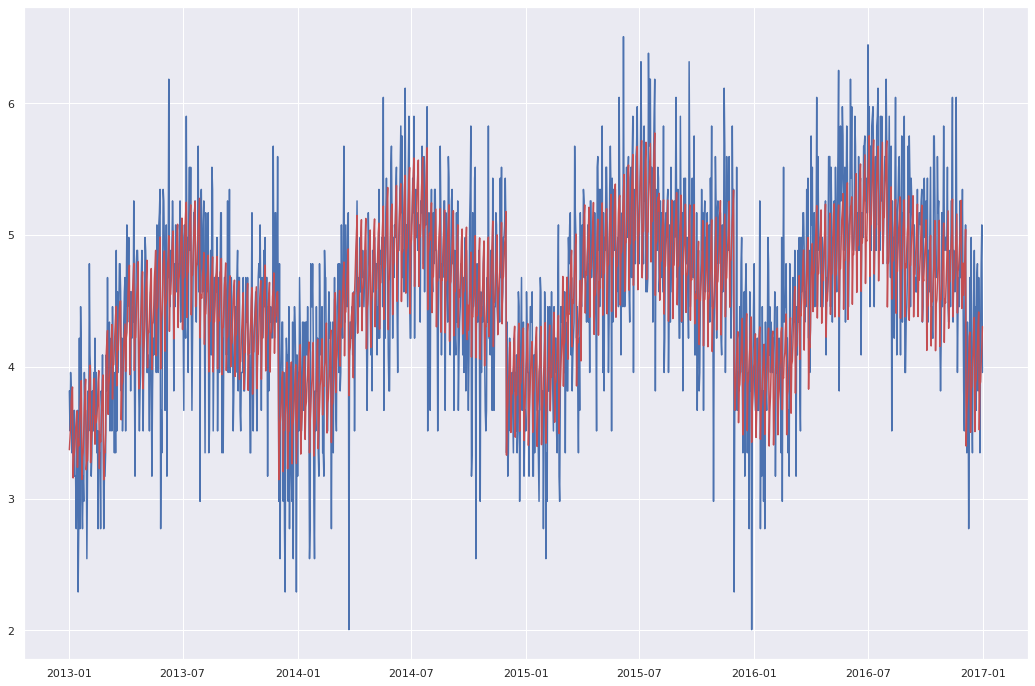

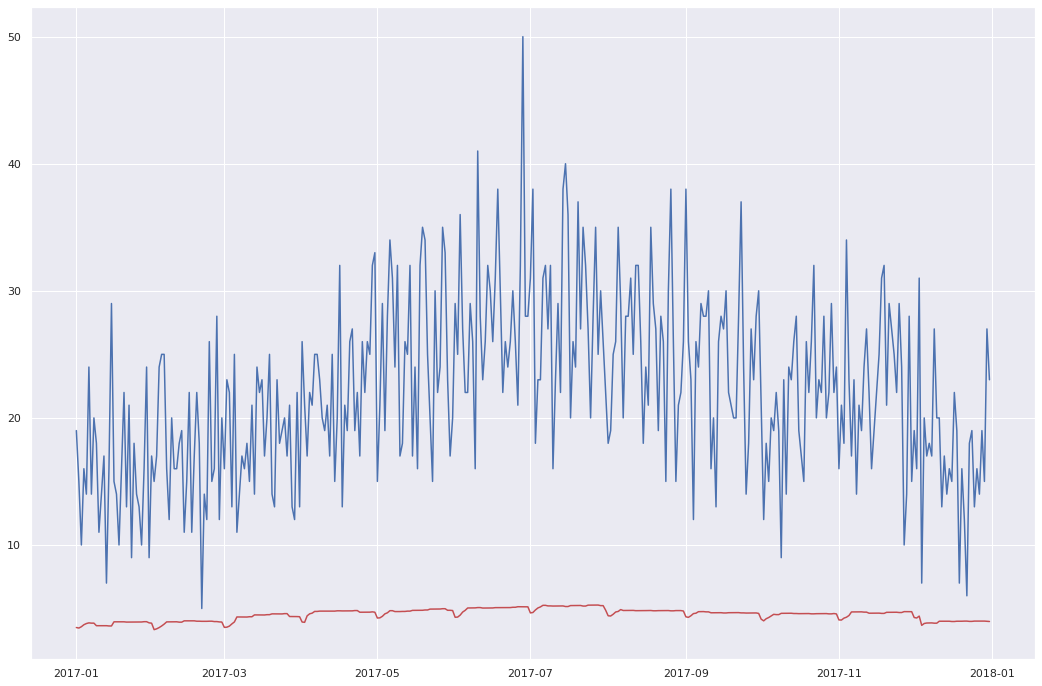

In [77]:
def show_pred(feature: pd.DataFrame, model: lgb.LGBMModel) -> None:
    train_y = feature["sales"]
    train_x = feature.reset_index().drop(["date", "sales"], axis=1)

    pred_train = model.predict(train_x, num_iteration=model.best_iteration)

    df_pred_train = pd.DataFrame({
        "store": feature["store"],
        "item": feature["item"],
        "sales": train_y,
        "pred": pred_train,
    })

    plt.figure(figsize=(18, 12))
    df_pred_train_group = df_pred_train.groupby(["store", "item"])
    for key, group in df_pred_train_group:
        plt.plot(group.index, group["sales"], color="b")
        plt.plot(group.index, group["pred"], color="r")
        break
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()


show_pred(df_train_feature, lgb_model)
show_pred(df_test_feature, lgb_model)